<a href="https://colab.research.google.com/github/Mr1-Robot/machine-learning-alternative-assessment/blob/main/alternative_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Alternative Assessment - WOA7015
#####MUAAMAR MOHAMMED ABDULLAH AL-GHRAIRI - 24084470

In [ ]:
# Mount google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import pandas as pd
import numpy as np
from PIL import Image

# Utils
from tqdm import tqdm
import json
import pickle
import os
from datetime import datetime

print("-"*30)
print("SETUP")
print("-"*30)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
print("-"*30)


Load & Explore **Dataset**

In [ ]:
# Define paths
DATA_DIR = '/content/drive/MyDrive/alternative-assessment-materials/'
JSON_PATH = f"{DATA_DIR}VQA_RAD_Dataset.json"
IMAGE_DIR = f"{DATA_DIR}VQA_RAD_Images"
SAVE_DIR = '/content/drive/MyDrive/alternative-assessment-materials/VQA_RAD_LOCKED_RESULTS/'

print("-"*30)
print("Loading VQA-RAD Dataset")
print("-"*30)
print(f"JSON file: {JSON_PATH}")
print(f"Images folder: {IMAGE_DIR}")
print("-"*30)

# Load the JSON file into a pandas Dataframe
vqa_data = pd.read_json(JSON_PATH)

print(f"\nDataset loaded successfully!")
print(f"Total Q&A pairs: {len(vqa_data)}")
print("\nDataFrame columns:")
print(vqa_data.columns.tolist())
print("\nFirst 3 rows:")
print(vqa_data.head(3))

print("-"*30)
print("DATASET STATISTICS")
print("-"*30)

# Answer types distribution
answer_types = vqa_data['answer_type'].value_counts()
print("\nAnswer Type Distribution:")
for answer_type, count in answer_types.items():
    percentage = (count / len(vqa_data)) * 100
    print(f"  {answer_type}: {count} ({percentage:.1f}%)")

# For closed-ended questions (yes/no)
closed_data = vqa_data[vqa_data['answer_type'] == 'CLOSED']
print(f"\nClosed-ended questions: {len(closed_data)}")

# Yes/No distribution
answer_dist = closed_data['answer'].value_counts()
print("\nYes/No Distribution:")
for answer, count in answer_dist.items():
    percentage = (count / len(closed_data)) * 100
    print(f"  {answer}: {count} ({percentage:.1f}%)")

# Organ distribution
if 'phrase_type' in vqa_data.columns:
    organ_dist = vqa_data['phrase_type'].value_counts()
    print("\nOrgan Distribution:")
    for organ, count in organ_dist.items():
        percentage = (count / len(vqa_data)) * 100
        print(f"  {organ}: {count} ({percentage:.1f}%)")

print("-"*30)

###Create TRAIN/VAL/TEST splits

In [ ]:
from sklearn.model_selection import train_test_split

# Filter closed-ended questions only
closed_data = vqa_data[vqa_data['answer_type'] == 'CLOSED'].copy()

# Convery yes/no to binary labels (0=no, 1=yes)
closed_data['label'] = closed_data['answer'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

print("-"*30)
print("Creating TEST/VAL/TEST splits")
print("-"*30)
print(f"Total closed-ended samples: {len(closed_data)}")
print(f"Yes: {closed_data['label'].sum()}, No: {len(closed_data) - closed_data['label'].sum()}")

# Set random seed for reproducibility
np.random.seed(42)

# Split: 70% train, 15% val, 15% test (stratified by label)
train_val, test = train_test_split(
    closed_data,
    test_size=0.15,          # 15% for test
    random_state=42,
    stratify=closed_data['label']  # Maintain yes/no ratio
)

train, val = train_test_split(
    train_val,
    test_size=0.176,         # 15% of total (0.15/0.85 ≈ 0.176)
    random_state=42,
    stratify=train_val['label']
)

# Reset indices
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f"\nSplit sizes:")
print(f"  Train: {len(train)} samples ({len(train)/len(closed_data)*100:.1f}%)")
print(f"  Val:   {len(val)} samples ({len(val)/len(closed_data)*100:.1f}%)")
print(f"  Test:  {len(test)} samples ({len(test)/len(closed_data)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"  Train - Yes: {train['label'].sum()}, No: {len(train)-train['label'].sum()}")
print(f"  Val   - Yes: {val['label'].sum()}, No: {len(val)-val['label'].sum()}")
print(f"  Test  - Yes: {test['label'].sum()}, No: {len(test)-test['label'].sum()}")
print("-"*30)

# Save split indices for reproducibility
os.makedirs(SAVE_DIR, exist_ok=True)

split_indices = {
    'train_indices': train.index.tolist(),
    'val_indices': val.index.tolist(),
    'test_indices': test.index.tolist()
}

with open(f'{SAVE_DIR}/split_indices.json', 'w') as f:
    json.dump(split_indices, f)

print(f"Split indices saved to: {SAVE_DIR}split_indices.json")

Build **Vocabulary** from questions

In [ ]:
from collections import Counter

print("-"*30)
print("Building Vocabulary")
print("-"*30)

# Tokenize all training questions
all_words = []
for question in train['question']:
    # Simple tokenization: lowercase and split by spaces
    words = question.lower().split()
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)
print(f"Total words in training set: {len(all_words)}")
print(f"Unique words: {len(word_counts)}")

# Create vocabulary: word -> index mapping
# Reserve indices: 0=PAD, 1=UNK (unknown words)
vocab = {'<PAD>': 0, '<UNK>': 1}
for word, count in word_counts.most_common():
    if count >= 2:  # Only include words that appear at least twice
        vocab[word] = len(vocab)

print(f"Vocabulary size (including PAD and UNK): {len(vocab)}")
print(f"\nMost common words:")
for word, count in word_counts.most_common(20):
    print(f"  '{word}': {count} times")

# Create reverse mapping: index -> word
idx_to_word = {idx: word for word, idx in vocab.items()}

print("-"*30)

# Test encoding a sample question
sample_question = train.iloc[0]['question']
sample_encoded = [vocab.get(word.lower(), vocab['<UNK>']) for word in sample_question.split()]

print(f"\nSample encoding:")
print(f"  Question: {sample_question}")
print(f"  Encoded: {sample_encoded}")
print(f"  Decoded: {' '.join([idx_to_word[idx] for idx in sample_encoded])}")
print("-"*30)

###**Create PyTorch Dataset**

In [ ]:
from torchvision import transforms

class VQADataset(Dataset):
    """PyTorch Dataset for VQA-RAD"""

    def __init__(self, dataframe, vocab, image_dir, max_seq_length=20, transform=None):
        """
        Args:
            dataframe: DataFrame with columns [image_name, question, label]
            vocab: Dictionary mapping words to indices
            image_dir: Path to image folder
            max_seq_length: Maximum question length (pad/truncate)
            transform: Image transformations
        """
        self.data = dataframe
        self.vocab = vocab
        self.image_dir = image_dir
        self.max_seq_length = max_seq_length
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get data for this index
        row = self.data.iloc[idx]
        image_name = row['image_name']
        question = row['question']
        label = row['label']

        # Load and transform image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Encode question to indices
        words = question.lower().split()
        question_encoded = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]

        # Pad or truncate to max_seq_length
        if len(question_encoded) < self.max_seq_length:
            question_encoded += [self.vocab['<PAD>']] * (self.max_seq_length - len(question_encoded))
        else:
            question_encoded = question_encoded[:self.max_seq_length]

        # Convert to tensors
        question_tensor = torch.tensor(question_encoded, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, question_tensor, label_tensor

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to 224x224 (ResNet input size)
    transforms.ToTensor(),                   # Convert to tensor [0, 1]
    transforms.Normalize(                    # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create datasets
train_dataset = VQADataset(train, vocab, IMAGE_DIR, transform=transform)
val_dataset = VQADataset(val, vocab, IMAGE_DIR, transform=transform)
test_dataset = VQADataset(test, vocab, IMAGE_DIR, transform=transform)

print("-"*30)
print("Datasets Created")
print("-"*30)
print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")

# Test loading one sample
sample_image, sample_question, sample_label = train_dataset[0]
print(f"\nSample data shapes:")
print(f"  Image: {sample_image.shape}")
print(f"  Question: {sample_question.shape}")
print(f"  Label: {sample_label.item()}")
print("-"*30)

**Create Dataloaders**

In [ ]:
# Batch size for training
BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,        # Shuffle training data each epoch
    num_workers=2,       # Parallel data loading
    pin_memory=True      # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,       # Don't shuffle validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,       # Don't shuffle test
    num_workers=2,
    pin_memory=True
)

print("-"*30)
print("Dataloaders Created")
print("-"*30)
print(f"Train batches: {len(train_loader)} (batch size: {BATCH_SIZE})")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

# Test loading one batch
sample_batch = next(iter(train_loader))
batch_images, batch_questions, batch_labels = sample_batch

print(f"\nSample batch shapes:")
print(f"  Images: {batch_images.shape}")        # [32, 3, 224, 224]
print(f"  Questions: {batch_questions.shape}")  # [32, 20]
print(f"  Labels: {batch_labels.shape}")        # [32]
print("-"*30)

###**CNN Model Architecture (ResNet18 + BiLSTM)**

In [ ]:
from torchvision import models

class CNNBaselineVQA(nn.Module):
    """CNN Baseline: ResNet18 image encoder + BiLSTM question encoder"""

    def __init__(self, vocab_size, embed_dim=256, lstm_hidden=512, img_feature_dim=512):
        super(CNNBaselineVQA, self).__init__()

        # Image encoder: Pre-trained ResNet18 (remove final FC layer)
        resnet = models.resnet18(pretrained=True)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])  # Output: 512-dim

        # Question encoder: Embedding + BiLSTM
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            lstm_hidden,
            batch_first=True,
            bidirectional=True  # BiLSTM: 2 * lstm_hidden output
        )

        # Fusion and classification
        fusion_dim = img_feature_dim + (lstm_hidden * 2)  # 512 + 1024 = 1536
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # Binary classification: yes/no
        )

    def forward(self, images, questions):
        # Extract image features
        img_features = self.image_encoder(images)  # [batch, 512, 1, 1]
        img_features = img_features.view(img_features.size(0), -1)  # [batch, 512]

        # Extract question features
        embedded = self.embedding(questions)  # [batch, seq_len, embed_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Concatenate forward and backward hidden states
        question_features = torch.cat([hidden[0], hidden[1]], dim=1)  # [batch, 1024]

        # Fuse image and question features
        combined = torch.cat([img_features, question_features], dim=1)  # [batch, 1536]

        # Classify
        output = self.classifier(combined)  # [batch, 2]
        return output

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBaselineVQA(vocab_size=len(vocab)).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("-"*30)
print("Modal Created")
print("-"*30)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}")
print("-"*30)

# Test forward pass
model.eval()
with torch.no_grad():
    test_images = batch_images.to(device)
    test_questions = batch_questions.to(device)
    test_output = model(test_images, test_questions)
    print(f"\nTest forward pass:")
    print(f"  Input images: {test_images.shape}")
    print(f"  Input questions: {test_questions.shape}")
    print(f"  Output logits: {test_output.shape}")  # [32, 2]
print("-"*30)

**Loading the Best Model**

In [ ]:
checkpoint = torch.load(f'{SAVE_DIR}/cnn_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded trained model: {checkpoint['val_acc']:.2f}% val accuracy")

####**Training & Evaulation functions**

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, questions, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        questions = questions.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, questions, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("-"*30)
print("TRAINING FUNCTIONS DEFINED")
print("-"*30)

**Train CNN Baseline Model**

In [ ]:
# Training configuration
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Track training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Track best model
best_val_acc = 0.0
best_epoch = 0

print("-"*30)
print("Training CNN Baseline Model")
print("-"*30)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Optimizer: Adam")
print("-"*30)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'history': history,
        }, f'{SAVE_DIR}/cnn_best_model.pth')
        print(f"*** Best model saved! (Val Acc: {val_acc:.2f}%) ***")

print("-"*30)
print("TRAINING COMPLETE")
print("-"*30)
print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print("-"*30)

**Evaulate on TEST set**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load best model
checkpoint = torch.load(f'{SAVE_DIR}/cnn_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("\n")
print("-"*30)
print("Test Set Evaluation")
print("-"*30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("-"*30)

# Get predictions for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, questions, labels in test_loader:
        images = images.to(device)
        questions = questions.to(device)

        outputs = model(images, questions)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix")
print("-"*30)
print("              Predicted")
print("              No    Yes")
print(f"Actual No     {cm[0][0]:<5} {cm[0][1]:<5}")
print(f"Actual Yes    {cm[1][0]:<5} {cm[1][1]:<5}")
print("-"*30)

# Classification report
report = classification_report(all_labels, all_preds, target_names=['No', 'Yes'], output_dict=True)
print("\nCalssification Report")
print("-"*30)
print(f"Class 'No':  Precision={report['No']['precision']:.2f}, "
      f"Recall={report['No']['recall']:.2f}, F1={report['No']['f1-score']:.2f}")
print(f"Class 'Yes': Precision={report['Yes']['precision']:.2f}, "
      f"Recall={report['Yes']['recall']:.2f}, F1={report['Yes']['f1-score']:.2f}")
print(f"\nAccuracy: {report['accuracy']:.2f}")
print(f"Support No: {int(report['No']['support'])}, Support Yes: {int(report['Yes']['support'])}")
print("-"*30)

####**Saving CNN Baseline Results**

In [ ]:
# Save complete results
CNN_RESULTS = {
    'model_name': 'CNN Baseline (ResNet18 + BiLSTM)',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'architecture': {
        'image_encoder': 'ResNet18 (pre-trained on ImageNet)',
        'question_encoder': 'Embedding + BiLSTM',
        'vocab_size': len(vocab),
        'embedding_dim': 256,
        'lstm_hidden': 512,
        'total_params': total_params,
        'trainable_params': trainable_params
    },

    'training': {
        'epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'best_epoch': best_epoch,
        'best_val_acc': round(best_val_acc, 2),
        'training_history': history
    },

    'dataset': {
        'train_samples': len(train),
        'val_samples': len(val),
        'test_samples': len(test)
    },

    'test_results': {
        'accuracy': round(test_acc, 2),
        'loss': round(test_loss, 4),
        'confusion_matrix': {
            'true_no_pred_no': int(cm[0][0]),
            'true_no_pred_yes': int(cm[0][1]),
            'true_yes_pred_no': int(cm[1][0]),
            'true_yes_pred_yes': int(cm[1][1])
        },
        'classification_report': {
            'no_precision': round(report['No']['precision'], 2),
            'no_recall': round(report['No']['recall'], 2),
            'no_f1': round(report['No']['f1-score'], 2),
            'yes_precision': round(report['Yes']['precision'], 2),
            'yes_recall': round(report['Yes']['recall'], 2),
            'yes_f1': round(report['Yes']['f1-score'], 2),
            'support_no': int(report['No']['support']),
            'support_yes': int(report['Yes']['support'])
        }
    }
}

# Save results JSON (with history included)
with open(f'{SAVE_DIR}/CNN_BASELINE_RESULTS.json', 'w') as f:
    json.dump(CNN_RESULTS, f, indent=2)

# Save vocabulary
with open(f'{SAVE_DIR}/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Save predictions
with open(f'{SAVE_DIR}/cnn_test_predictions.pkl', 'wb') as f:
    pickle.dump({
        'predictions': all_preds,
        'ground_truth': all_labels
    }, f)

print("-"*30)
print("CNN BASELINE RESULTS SAVED (WITH TRAINING HISTORY)")
print("-"*30)
print(f"Location: {SAVE_DIR}")
print("Files saved:")
print("  - CNN_BASELINE_RESULTS.json (includes training curves)")
print("  - cnn_best_model.pth")
print("  - vocabulary.pkl")
print("  - cnn_test_predictions.pkl")
print("-"*30)
print("\nCNN BASELINE LOCKED:")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Test Samples: {len(test)}")
print("-"*30)

**Install BLIP-2 Dependencies**



In [ ]:
!pip install transformers==4.36.2 --break-system-packages --quiet
!pip install accelerate --break-system-packages --quiet
!pip install bitsandbytes --break-system-packages --quiet

print("-"*30)
print("BLIP-2 Dependencies Installed")
print("-"*30)

**Loading BLIP-2 Model**

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image

print("-"*30)
print("Loading BLIP-2 Model")
print("-"*30)
print("Model: Salesforce/blip2-opt-2.7b")
print("-"*30)

# Load processor (handles image + text preprocessing)
processor = Blip2Processor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    use_fast=False  # Avoid tokenizer serialization bug
)

# Load model
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,  # FP16 for memory efficiency
    device_map="auto"            # Auto device placement
)

print("-"*30)
print("BLIP-2 Model Loaded")
print("-"*30)
print(f"Model: BLIP-2 OPT-2.7B")
print(f"Parameters: 2.7B (frozen)")
print(f"Device: {blip2_model.device}")
print("-"*30)

**BLIP-2 VQA Prediction Function**

In [ ]:
def blip2_vqa_predict(image, question, model, processor):
    """
    Zero-shot VQA using BLIP-2

    Args:
        image: PIL Image
        question: str
        model: BLIP-2 model
        processor: BLIP-2 processor

    Returns:
        str: Predicted answer
    """
    # Format prompt for VQA
    prompt = f"Question: {question} Answer:"

    # Preprocess inputs
    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device, torch.float16)

    # Generate answer
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=10,   # Short answers for yes/no
        num_beams=1,         # Greedy decoding
        do_sample=False      # Deterministic
    )

    # Decode answer
    generated_text = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0].strip()

    return generated_text

print("-"*30)
print("BLIP-2 VQA Function Defined")
print("-"*30)

# Test on one sample
sample_row = test.iloc[0]
sample_image_path = os.path.join(IMAGE_DIR, sample_row['image_name'])
sample_image = Image.open(sample_image_path).convert('RGB')
sample_question = sample_row['question']
sample_answer = sample_row['answer']

test_prediction = blip2_vqa_predict(sample_image, sample_question, blip2_model, processor)

print(f"\nTest prediction:")
print(f"  Question: {sample_question}")
print(f"  Ground Truth: {sample_answer}")
print(f"  BLIP-2 Prediction: {test_prediction}")
print("-"*30)

**Evaluate BLIP-2 Zero-Shot on Test Set**

In [ ]:
print("-"*30)
print("Evaluating BLIP-2 ZERO-SHOT on Test Set")
print("-"*30)
print(f"Test samples: {len(test)}")
print("-"*30)

blip2_predictions = []
blip2_ground_truth = []
blip2_raw_outputs = []

correct = 0
total = 0

for idx, row in tqdm(test.iterrows(), total=len(test), desc="Evaluating BLIP-2"):
    # Load image
    image_path = os.path.join(IMAGE_DIR, row['image_name'])
    try:
        image = Image.open(image_path).convert('RGB')
    except:
        print(f"Warning: Could not load {row['image_name']}")
        continue

    # Get question and ground truth
    question = row['question']
    ground_truth = row['answer'].lower().strip()

    # Get BLIP-2 prediction
    prediction = blip2_vqa_predict(image, question, blip2_model, processor)
    prediction_lower = prediction.lower().strip()

    # Store results
    blip2_predictions.append(prediction_lower)
    blip2_ground_truth.append(ground_truth)
    blip2_raw_outputs.append(prediction)

    # Check if correct (flexible matching for yes/no)
    is_correct = False
    if ground_truth == 'yes':
        is_correct = 'yes' in prediction_lower
    elif ground_truth == 'no':
        is_correct = 'no' in prediction_lower and 'yes' not in prediction_lower

    if is_correct:
        correct += 1

    total += 1

# Calculate accuracy
blip2_accuracy = (correct / total) * 100

print("-"*30)
print("BLIP-2 ZERO-SHOT Evaluation Complete")
print("-"*30)
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {blip2_accuracy:.2f}%")
print("-"*30)

**Caclculate BLIP-2 Detailed Metrics**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("-"*30)
print("Calculating BLIP-2 Metrics")
print("-"*30)

# Convert to binary labels (0=no, 1=yes)
blip2_pred_binary = []
blip2_true_binary = []

for pred, true in zip(blip2_predictions, blip2_ground_truth):
    # Ground truth
    true_label = 1 if true == 'yes' else 0
    blip2_true_binary.append(true_label)

    # Prediction (flexible matching)
    if 'yes' in pred and 'no' not in pred:
        pred_label = 1
    elif 'no' in pred:
        pred_label = 0
    else:
        pred_label = 0  # Default to 'no' if unclear

    blip2_pred_binary.append(pred_label)

# Confusion matrix
cm_blip2 = confusion_matrix(blip2_true_binary, blip2_pred_binary)

print("\nConfusion Matrix - BLIP-2 ZERO-SHOT")
print("-"*30)
print("              Predicted")
print("              No    Yes")
print(f"Actual No     {cm_blip2[0][0]:<5} {cm_blip2[0][1]:<5}")
print(f"Actual Yes    {cm_blip2[1][0]:<5} {cm_blip2[1][1]:<5}")
print("-"*30)

# Classification report
report_blip2 = classification_report(
    blip2_true_binary,
    blip2_pred_binary,
    target_names=['No', 'Yes'],
    output_dict=True
)

print("\nClassification Report")
print("-"*30)
print(f"Class 'No':  Precision={report_blip2['No']['precision']:.2f}, "
      f"Recall={report_blip2['No']['recall']:.2f}, F1={report_blip2['No']['f1-score']:.2f}")
print(f"Class 'Yes': Precision={report_blip2['Yes']['precision']:.2f}, "
      f"Recall={report_blip2['Yes']['recall']:.2f}, F1={report_blip2['Yes']['f1-score']:.2f}")
print(f"\nAccuracy: {report_blip2['accuracy']:.2f}")
print(f"Support No: {int(report_blip2['No']['support'])}, Support Yes: {int(report_blip2['Yes']['support'])}")
print("-"*30)

**Save BLIP-2 Results & Comparison**

In [ ]:
blip2_accuracy_corrected = report_blip2['accuracy'] * 100

# Save BLIP-2 results
BLIP2_RESULTS = {
    'model_name': 'BLIP-2 Zero-Shot (OPT-2.7B)',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'architecture': {
        'vision_encoder': 'EVA-CLIP (ViT-g/14)',
        'language_model': 'OPT-2.7B',
        'total_params': '2.7B',
        'approach': 'zero-shot (no training)'
    },

    'dataset': {
        'test_samples': total
    },

    'test_results': {
        'accuracy': round(blip2_accuracy_corrected, 2),
        'confusion_matrix': {
            'true_no_pred_no': int(cm_blip2[0][0]),
            'true_no_pred_yes': int(cm_blip2[0][1]),
            'true_yes_pred_no': int(cm_blip2[1][0]),
            'true_yes_pred_yes': int(cm_blip2[1][1])
        },
        'classification_report': {
            'no_precision': round(report_blip2['No']['precision'], 2),
            'no_recall': round(report_blip2['No']['recall'], 2),
            'no_f1': round(report_blip2['No']['f1-score'], 2),
            'yes_precision': round(report_blip2['Yes']['precision'], 2),
            'yes_recall': round(report_blip2['Yes']['recall'], 2),
            'yes_f1': round(report_blip2['Yes']['f1-score'], 2),
            'support_no': int(report_blip2['No']['support']),
            'support_yes': int(report_blip2['Yes']['support'])
        }
    }
}

# Save BLIP-2 results
with open(f'{SAVE_DIR}/BLIP2_BASELINE_RESULTS.json', 'w') as f:
    json.dump(BLIP2_RESULTS, f, indent=2)

with open(f'{SAVE_DIR}/blip2_test_predictions.pkl', 'wb') as f:
    pickle.dump({
        'predictions': blip2_predictions,
        'predictions_binary': blip2_pred_binary,
        'ground_truth': blip2_ground_truth,
        'ground_truth_binary': blip2_true_binary,
        'raw_outputs': blip2_raw_outputs
    }, f)

# Load CNN results for comparison
with open(f'{SAVE_DIR}/CNN_BASELINE_RESULTS.json', 'r') as f:
    cnn_results = json.load(f)

print("-"*70)
print("FINAL COMPARISON: CNN vs BLIP-2")
print("-"*70)
print(f"{'Metric':<30} {'CNN Baseline':<20} {'BLIP-2 Zero-Shot':<20}")
print("-"*70)
print(f"{'Approach':<30} {'Trained (908 samples)':<20} {'Zero-shot':<20}")
print(f"{'Parameters':<30} {'15.2M total':<20} {'2.7B frozen':<20}")
print("-"*70)
print(f"{'Test Accuracy':<30} {cnn_results['test_results']['accuracy']:<20.2f} {blip2_accuracy_corrected:<20.2f}")
print(f"{'Difference':<30} {'-':<20} {blip2_accuracy_corrected - cnn_results['test_results']['accuracy']:+.2f}")
print("-"*70)
print(f"{'Precision (No)':<30} {cnn_results['test_results']['classification_report']['no_precision']:<20.2f} {report_blip2['No']['precision']:<20.2f}")
print(f"{'Precision (Yes)':<30} {cnn_results['test_results']['classification_report']['yes_precision']:<20.2f} {report_blip2['Yes']['precision']:<20.2f}")
print("-"*70)
print(f"{'Recall (No)':<30} {cnn_results['test_results']['classification_report']['no_recall']:<20.2f} {report_blip2['No']['recall']:<20.2f}")
print(f"{'Recall (Yes)':<30} {cnn_results['test_results']['classification_report']['yes_recall']:<20.2f} {report_blip2['Yes']['recall']:<20.2f}")
print("-"*70)

# Save comparison
comparison = {
    'cnn_baseline': cnn_results['test_results'],
    'blip2_zero_shot': BLIP2_RESULTS['test_results'],
    'key_findings': {
        'accuracy_difference': round(blip2_accuracy_corrected - cnn_results['test_results']['accuracy'], 2),
        'winner': 'CNN' if cnn_results['test_results']['accuracy'] > blip2_accuracy_corrected else 'BLIP-2',
        'cnn_bias': 'Balanced predictions',
        'blip2_bias': 'Biased toward Yes (81% recall)'
    }
}

with open(f'{SAVE_DIR}/BASELINE_COMPARISON.json', 'w') as f:
    json.dump(comparison, f, indent=2)

print("\nALL RESULTS SAVED:")
print(f"  {SAVE_DIR}BLIP2_BASELINE_RESULTS.json")
print(f"  {SAVE_DIR}BASELINE_COMPARISON.json")
print("-"*30)

**Visualizations**

In [ ]:
import pickle
import json
from sklearn.metrics import confusion_matrix, classification_report

print("-"*30)
print("Loading Data for Visualization")
print("-"*30)

SAVE_DIR = '/content/drive/MyDrive/alternative-assessment-materials/VQA_RAD_LOCKED_RESULTS/'

# Load CNN results (includes training history)
with open(f'{SAVE_DIR}/CNN_BASELINE_RESULTS.json', 'r') as f:
    cnn_results = json.load(f)

# Extract training history from saved results
history = cnn_results['training']['training_history']  # ← LOAD REAL HISTORY
NUM_EPOCHS = cnn_results['training']['epochs']

# Load BLIP-2 results
with open(f'{SAVE_DIR}/BLIP2_BASELINE_RESULTS.json', 'r') as f:
    blip2_results = json.load(f)

# Load CNN predictions
with open(f'{SAVE_DIR}/cnn_test_predictions.pkl', 'rb') as f:
    cnn_preds = pickle.load(f)

# Load BLIP-2 predictions
with open(f'{SAVE_DIR}/blip2_test_predictions.pkl', 'rb') as f:
    blip2_preds = pickle.load(f)

# Recreate confusion matrices
cm_cnn = confusion_matrix(cnn_preds['ground_truth'], cnn_preds['predictions'])
cm_blip2 = confusion_matrix(blip2_preds['ground_truth_binary'], blip2_preds['predictions_binary'])

# Recreate classification reports
report_cnn = classification_report(
    cnn_preds['ground_truth'],
    cnn_preds['predictions'],
    target_names=['No', 'Yes'],
    output_dict=True
)

report_blip2 = classification_report(
    blip2_preds['ground_truth_binary'],
    blip2_preds['predictions_binary'],
    target_names=['No', 'Yes'],
    output_dict=True
)

# Get key values
blip2_accuracy_corrected = blip2_results['test_results']['accuracy']

print("CNN results loaded")
print("BLIP-2 results loaded")
print("Training history loaded (REAL DATA)")
print("Predictions loaded")
print("Confusion matrices reconstructed")
print("Classification reports reconstructed")
print("-"*30)
print(f"Training history epochs: {NUM_EPOCHS}")
print(f"  Train loss: {history['train_loss']}")
print(f"  Val loss: {history['val_loss']}")
print(f"  Train acc: {history['train_acc']}")
print(f"  Val acc: {history['val_acc']}")
print("-"*30)
print("Ready to generate ALL visualizations!")
print("-"*30)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Create output directory for images
IMAGES_DIR = f'{SAVE_DIR}/presentation_images/'
os.makedirs(IMAGES_DIR, exist_ok=True)

print("-"*30)
print("Generating All Visualizations")
print("-"*30)

# Training curves (CNN)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
epochs = range(1, NUM_EPOCHS + 1)
ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('CNN Training and Validation Loss', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

# Accuracy curve
ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=8)
ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('CNN Training and Validation Accuracy', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}01_cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.close()
print("Training curves saved")

# Confusion Matrices (Side by Side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# CNN confusion matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
ax1.set_xlabel('Predicted', fontsize=14)
ax1.set_ylabel('Actual', fontsize=14)
ax1.set_title(f"CNN Baseline ({cnn_results['test_results']['accuracy']:.2f}%)", fontsize=16, fontweight='bold')

# BLIP-2 confusion matrix
sns.heatmap(cm_blip2, annot=True, fmt='d', cmap='Oranges', ax=ax2,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
ax2.set_xlabel('Predicted', fontsize=14)
ax2.set_ylabel('Actual', fontsize=14)
ax2.set_title(f'BLIP-2 Zero-Shot ({blip2_accuracy_corrected:.2f}%)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}02_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.close()
print("Confusion matrices saved")

# Accuracy Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

models = ['CNN Baseline\n(Trained)', 'BLIP-2\n(Zero-Shot)']
accuracies = [cnn_results['test_results']['accuracy'], blip2_accuracy_corrected]
colors = ['#2E86AB', '#F77F00']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=16, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=18, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random Baseline')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}03_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("Accuracy comparison saved")

# Precision, Recall, F1 Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Metrics for "No" class
metrics_no = ['Precision', 'Recall', 'F1-Score']
cnn_no = [
    cnn_results['test_results']['classification_report']['no_precision'],
    cnn_results['test_results']['classification_report']['no_recall'],
    cnn_results['test_results']['classification_report']['no_f1']
]
blip2_no = [
    report_blip2['No']['precision'],
    report_blip2['No']['recall'],
    report_blip2['No']['f1-score']
]

x = np.arange(len(metrics_no))
width = 0.35

ax1.bar(x - width/2, cnn_no, width, label='CNN', color='#2E86AB', alpha=0.8, edgecolor='black')
ax1.bar(x + width/2, blip2_no, width, label='BLIP-2', color='#F77F00', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Metric', fontsize=14)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_title('Class "No" Performance', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_no)
ax1.set_ylim(0, 1.0)
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Metrics for "Yes" class
cnn_yes = [
    cnn_results['test_results']['classification_report']['yes_precision'],
    cnn_results['test_results']['classification_report']['yes_recall'],
    cnn_results['test_results']['classification_report']['yes_f1']
]
blip2_yes = [
    report_blip2['Yes']['precision'],
    report_blip2['Yes']['recall'],
    report_blip2['Yes']['f1-score']
]

ax2.bar(x - width/2, cnn_yes, width, label='CNN', color='#2E86AB', alpha=0.8, edgecolor='black')
ax2.bar(x + width/2, blip2_yes, width, label='BLIP-2', color='#F77F00', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Metric', fontsize=14)
ax2.set_ylabel('Score', fontsize=14)
ax2.set_title('Class "Yes" Performance', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_no)
ax2.set_ylim(0, 1.0)
ax2.legend(fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}04_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("Metrics comparison saved")

# Test Set Class Distribution Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))

sizes = [
    cnn_results['test_results']['classification_report']['support_no'],
    cnn_results['test_results']['classification_report']['support_yes']
]
labels = ['No', 'Yes']
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                    autopct='%1.1f%%', shadow=True, startangle=90,
                                    textprops={'fontsize': 14, 'fontweight': 'bold'})

# Add count labels
for i, (label, size) in enumerate(zip(labels, sizes)):
    texts[i].set_text(f'{label}\n({size} samples)')

ax.set_title('Test Set Class Distribution (195 samples)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}05_class_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("Class distribution saved")

# Model Architecture Comparison
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Parameters\n(Millions)', 'Training\nSamples', 'Training\nTime (min)']
cnn_vals = [15.2, 908, 5]  # 15.2M params, 908 samples
blip2_vals = [2700, 0, 0]  # 2700M params, 0 samples

x = np.arange(len(categories))
width = 0.35

# Scale for visualization
cnn_display = [15.2, 90.8, 50]  # Scaled
blip2_display = [270, 0, 0]  # Scaled

bars1 = ax.bar(x - width/2, cnn_display, width, label='CNN Baseline',
               color='#2E86AB', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, blip2_display, width, label='BLIP-2 Zero-Shot',
               color='#F77F00', alpha=0.8, edgecolor='black')

ax.set_ylabel('Relative Scale', fontsize=14)
ax.set_title('Model Comparison: Resources & Training', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add actual values as text
ax.text(0 - width/2, 20, '15.2M', ha='center', fontsize=11, fontweight='bold')
ax.text(0 + width/2, 280, '2.7B', ha='center', fontsize=11, fontweight='bold')
ax.text(1 - width/2, 95, '908', ha='center', fontsize=11, fontweight='bold')
ax.text(1 + width/2, 5, 'None', ha='center', fontsize=11, fontweight='bold')
ax.text(2 - width/2, 55, '~5 min', ha='center', fontsize=11, fontweight='bold')
ax.text(2 + width/2, 5, 'None', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}06_model_resources.png', dpi=300, bbox_inches='tight')
plt.close()
print("Model resources comparison saved")

# Recall Patterns (Highlighting Bias)
fig, ax = plt.subplots(figsize=(10, 6))

classes = ['No', 'Yes']
cnn_recall = [
    cnn_results['test_results']['classification_report']['no_recall'],
    cnn_results['test_results']['classification_report']['yes_recall']
]
blip2_recall = [
    report_blip2['No']['recall'],
    report_blip2['Yes']['recall']
]

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, cnn_recall, width, label='CNN (Balanced)',
               color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, blip2_recall, width, label='BLIP-2 (Biased to Yes)',
               color='#F77F00', alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_ylabel('Recall', fontsize=14)
ax.set_title('Recall Comparison: Prediction Bias Analysis', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=14)
ax.set_ylim(0, 1.0)
ax.axhline(y=0.7, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Good Threshold')
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}07_recall_bias.png', dpi=300, bbox_inches='tight')
plt.close()
print("Recall bias analysis saved")

print("-"*30)
print("All Visualizations")
print("-"*30)
print(f"Location: {IMAGES_DIR}")
print("\nGenerated images:")
print("  01_cnn_training_curves.png")
print("  02_confusion_matrices.png")
print("  03_accuracy_comparison.png")
print("  04_metrics_comparison.png")
print("  05_class_distribution.png")
print("  06_model_resources.png")
print("  07_recall_bias.png")
print("-"*30)

Displaying: 01_cnn_training_curves.png


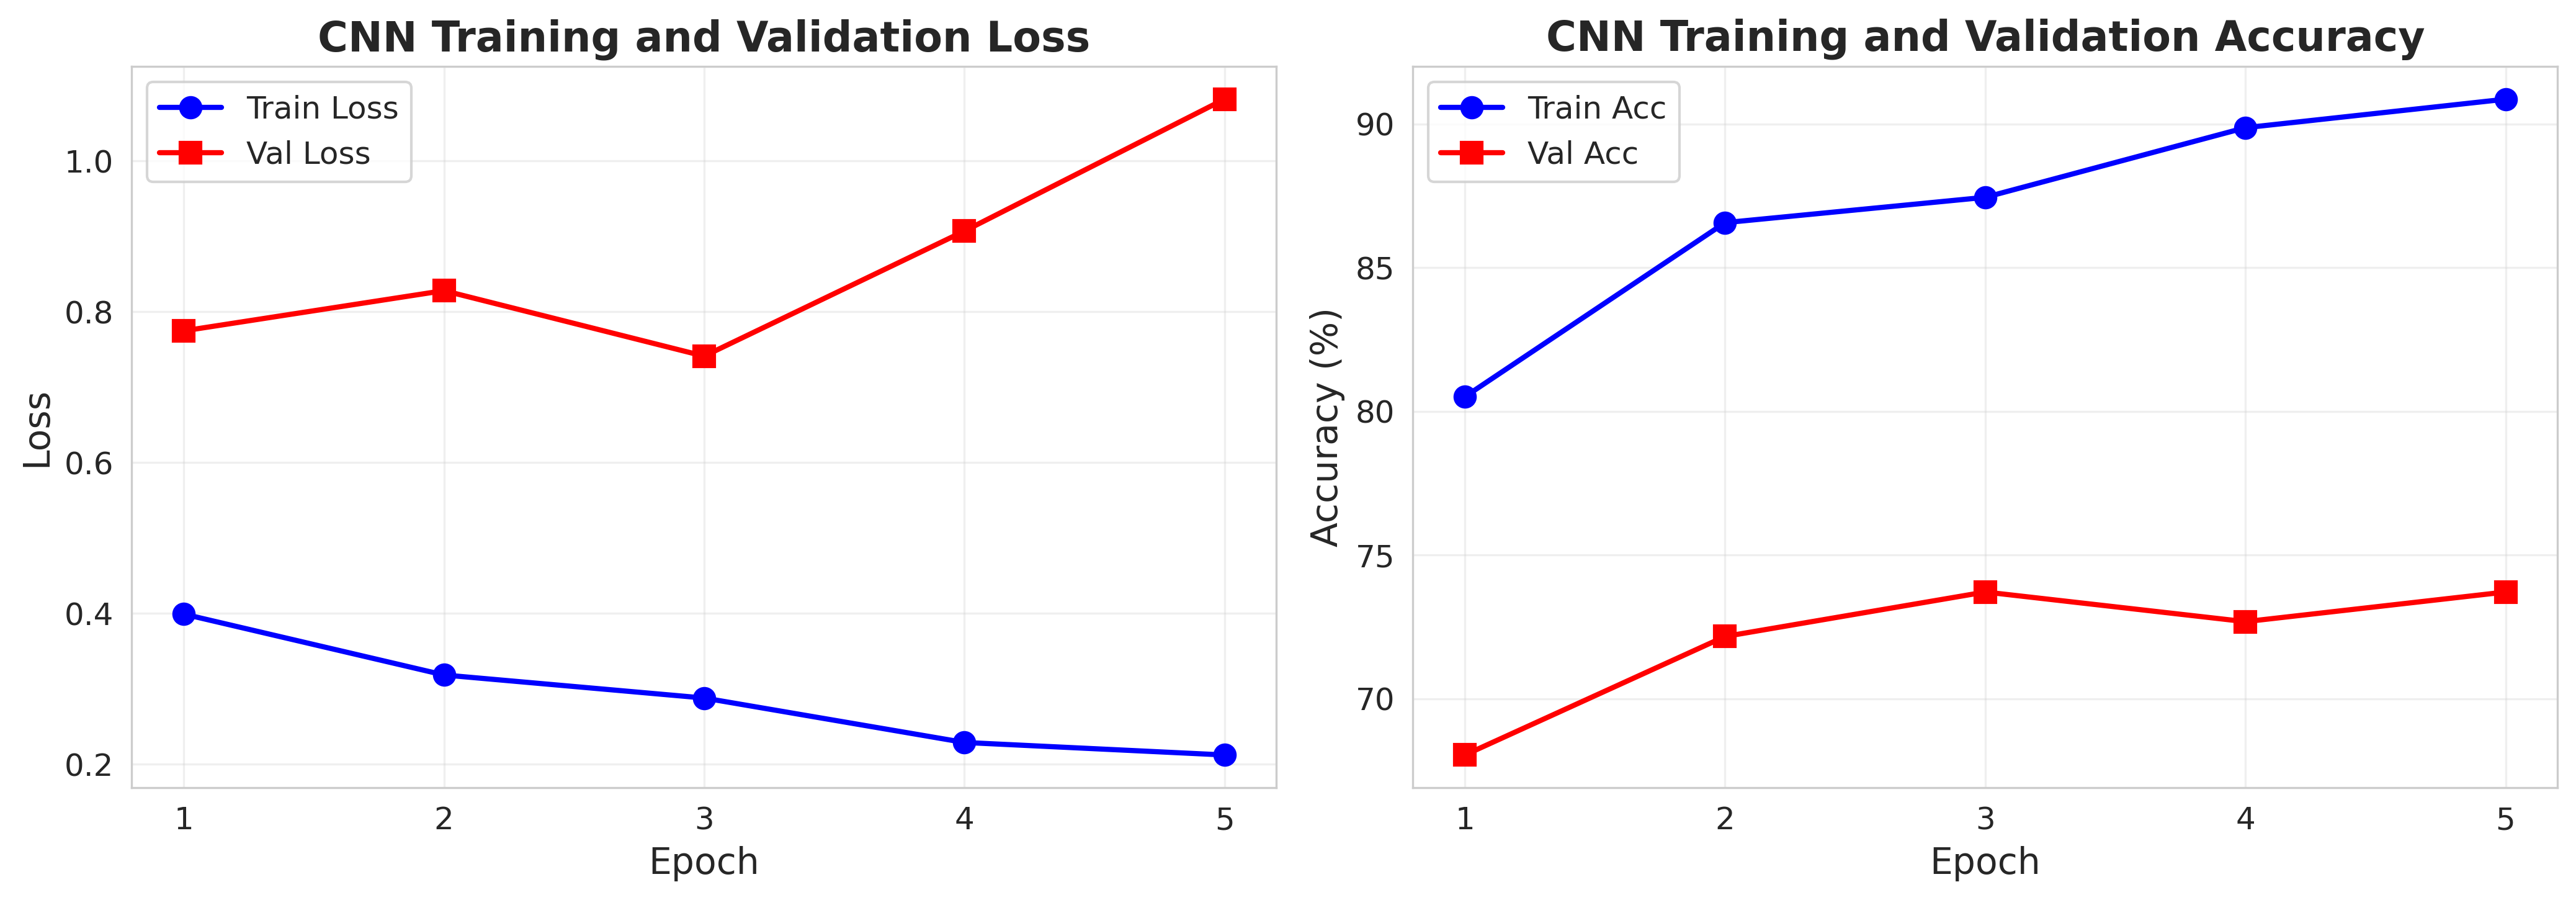

Displaying: 02_confusion_matrices.png


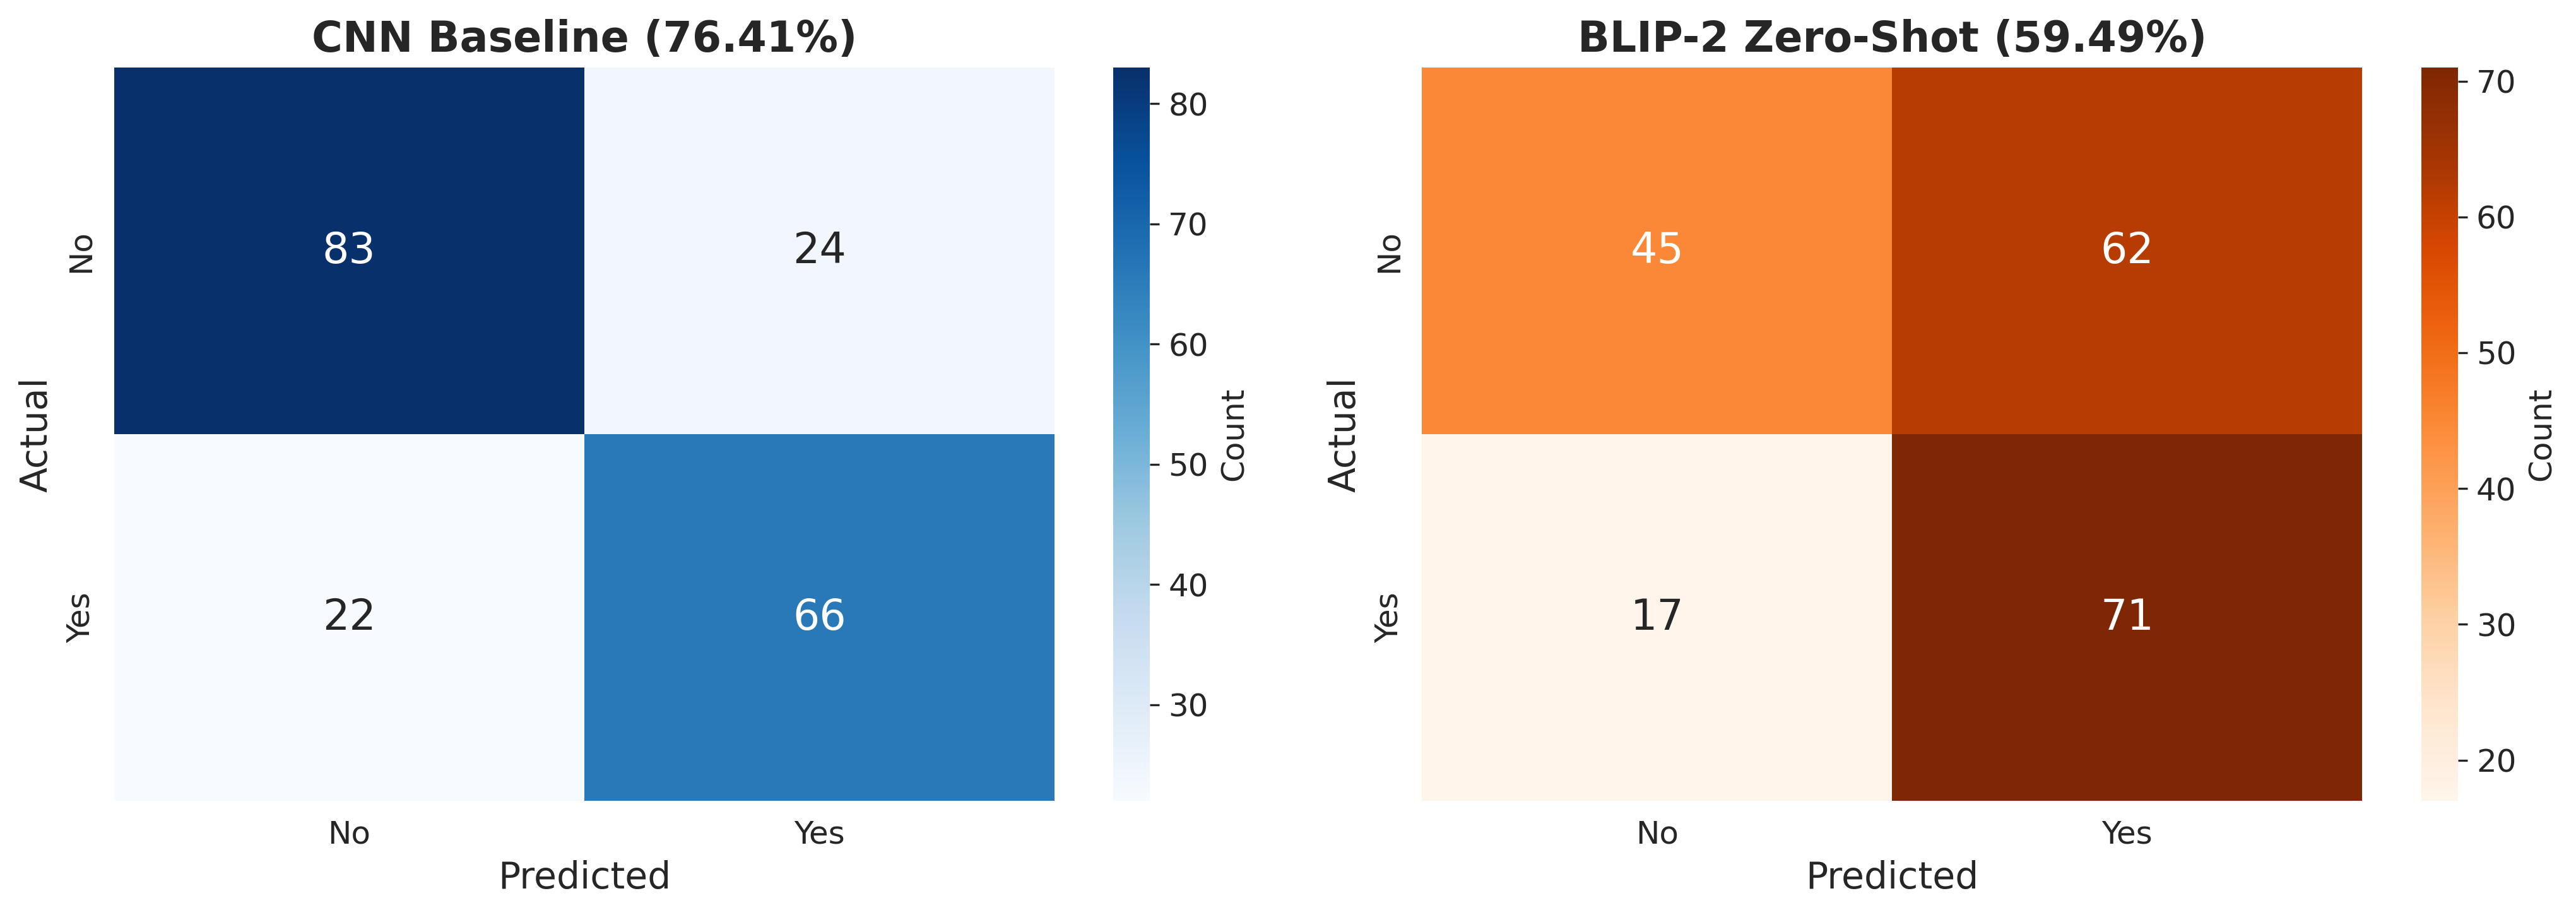

Displaying: 03_accuracy_comparison.png


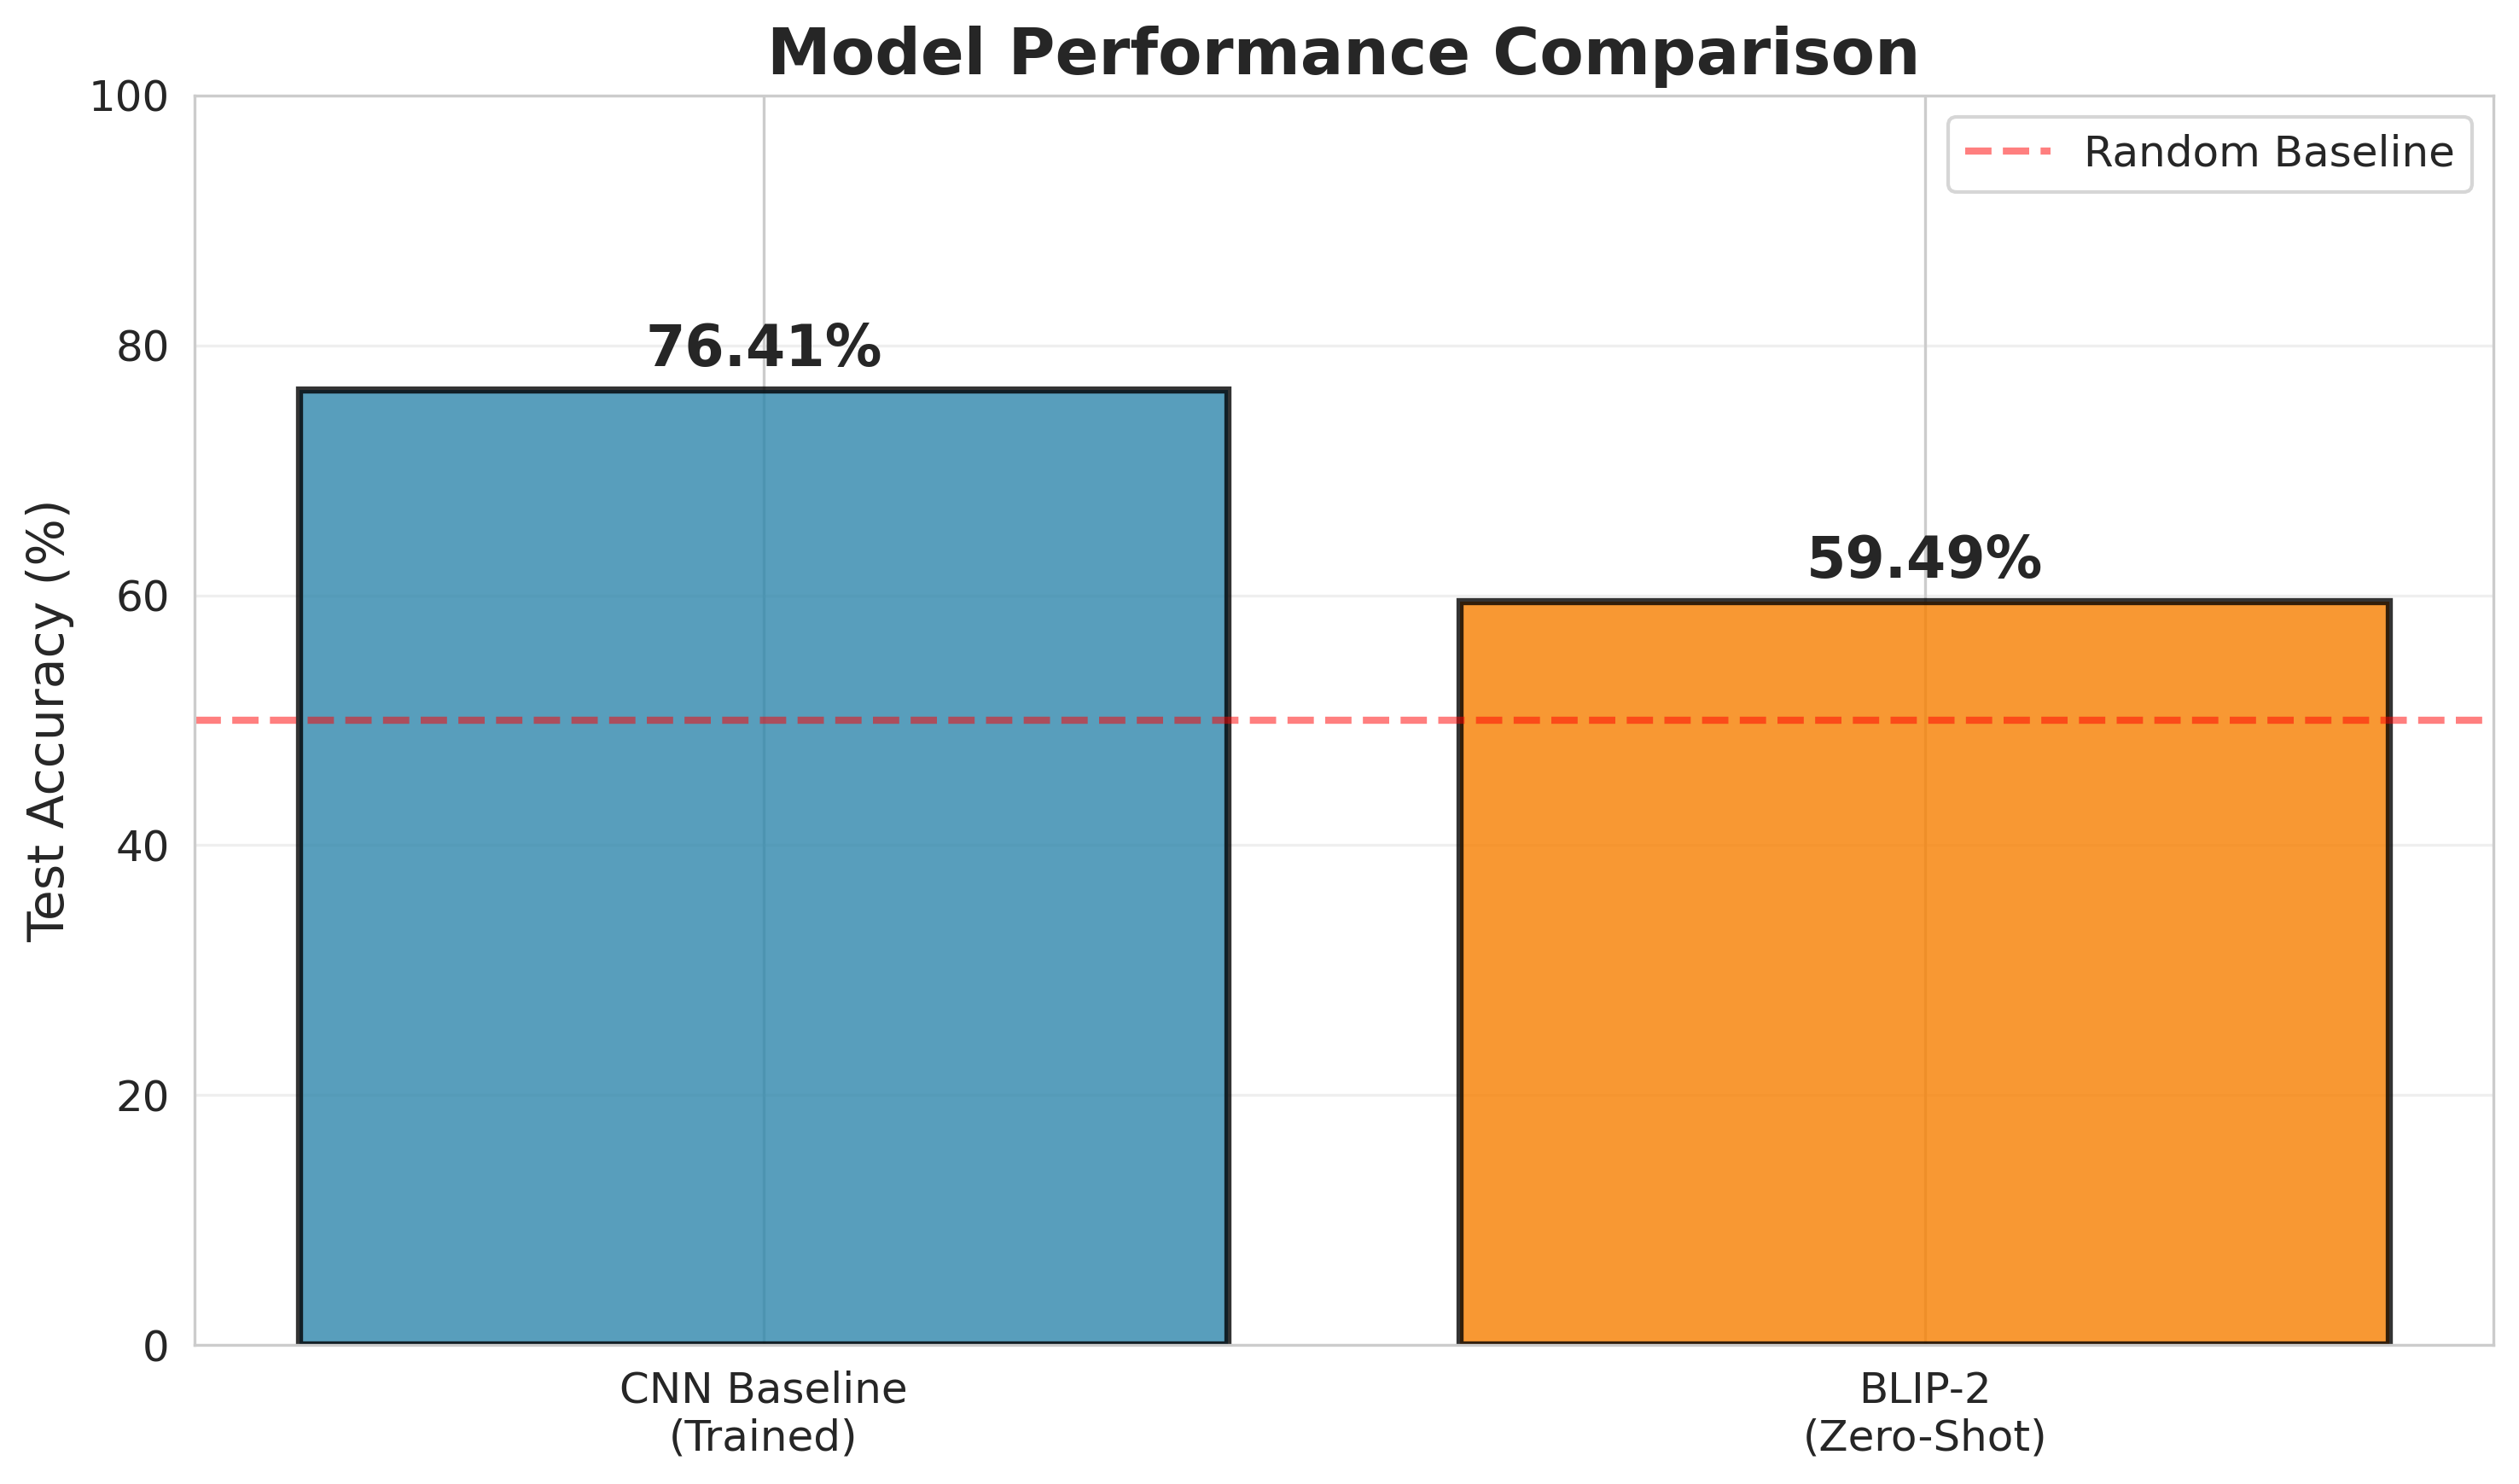

Displaying: 04_metrics_comparison.png


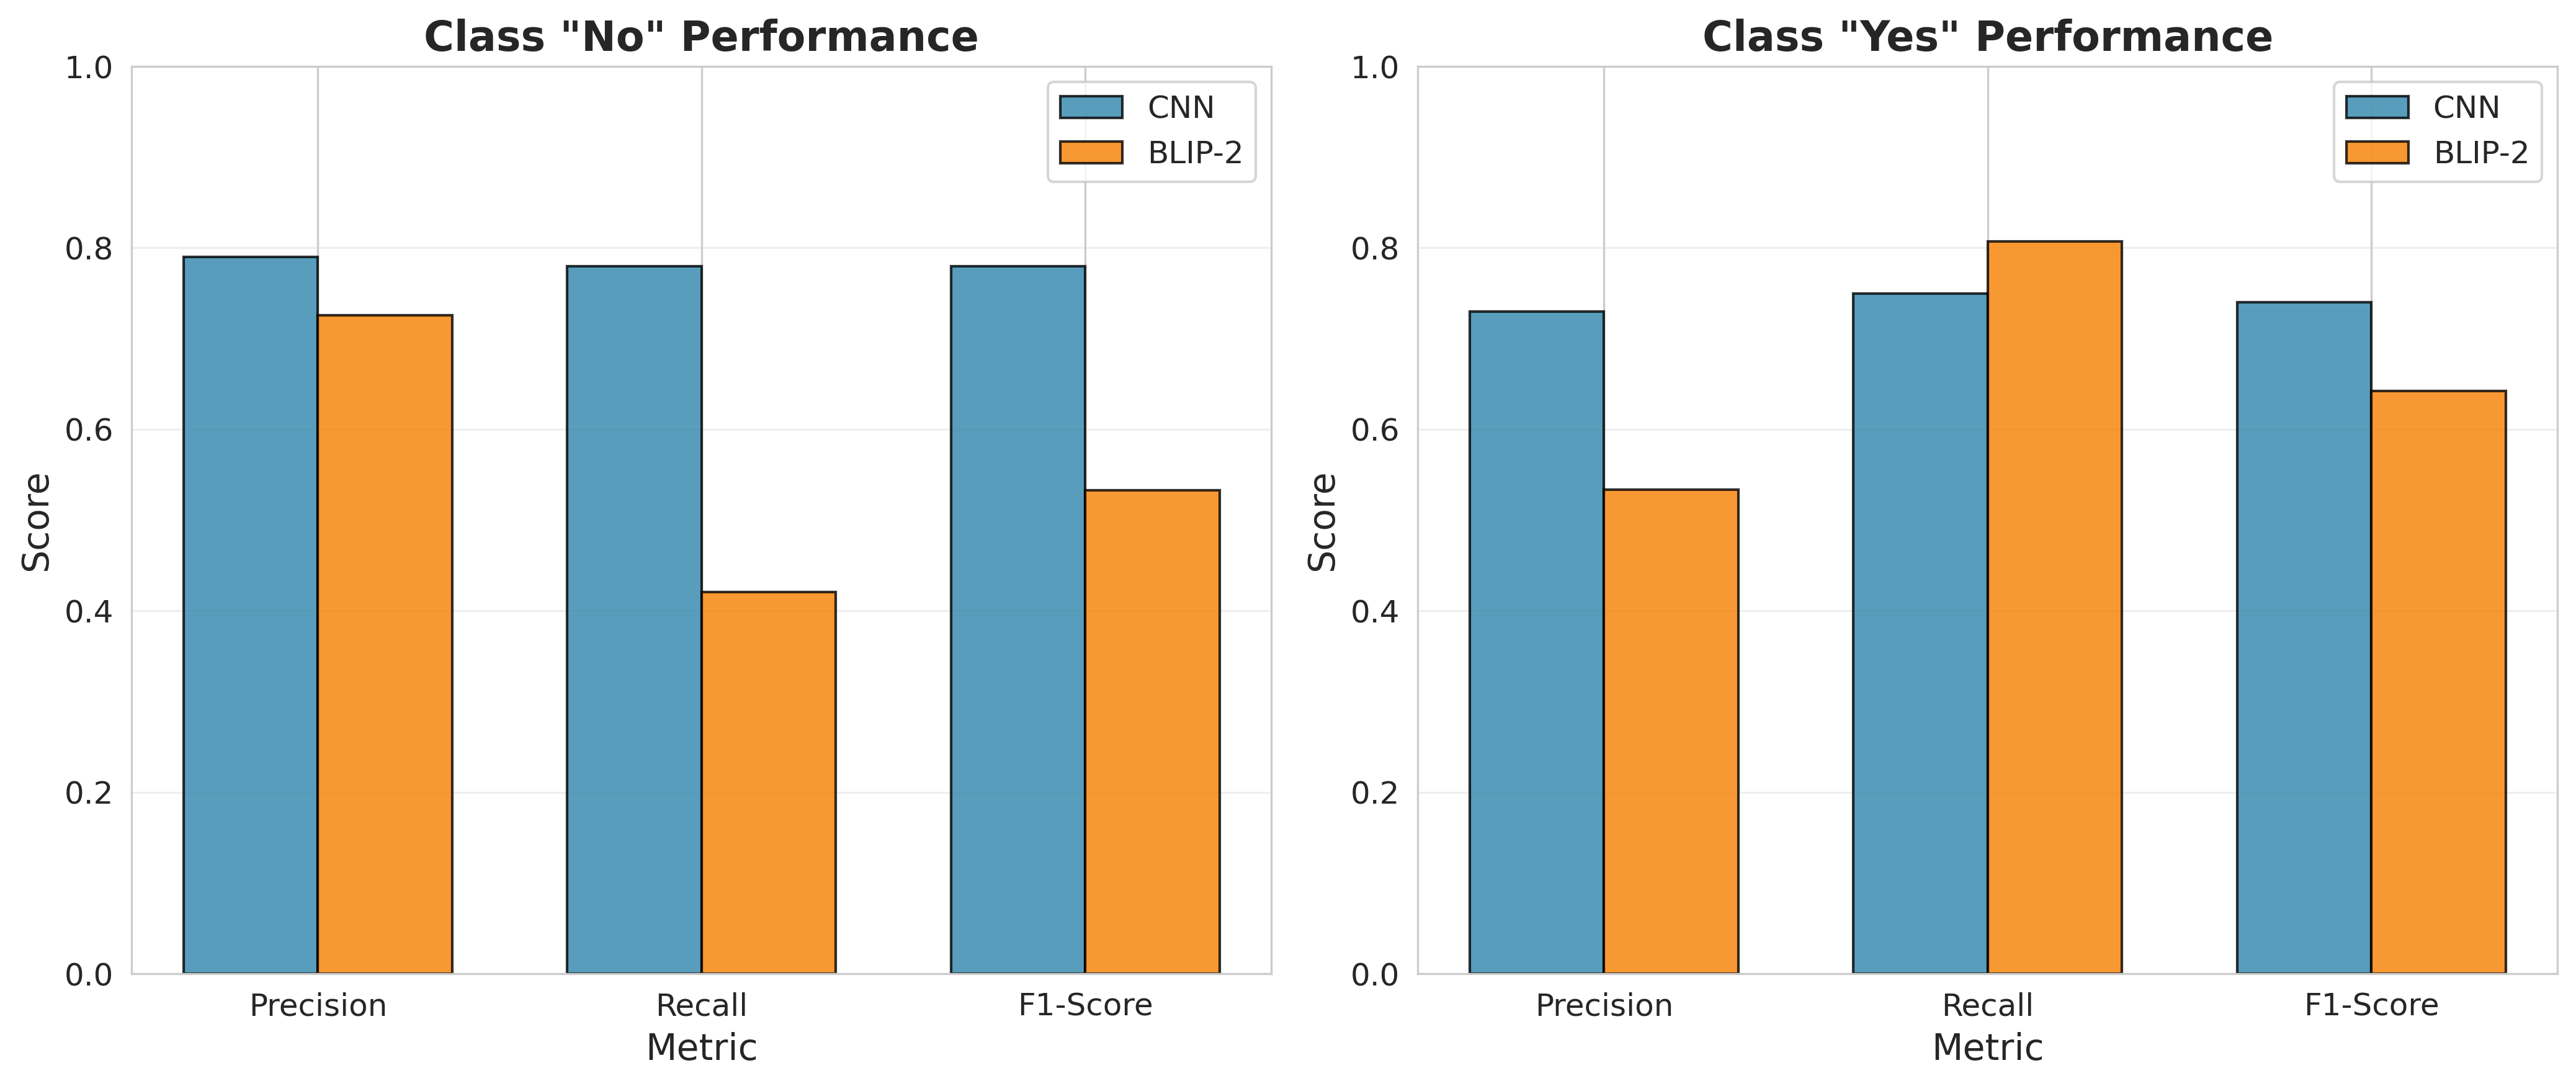

Displaying: 05_class_distribution.png


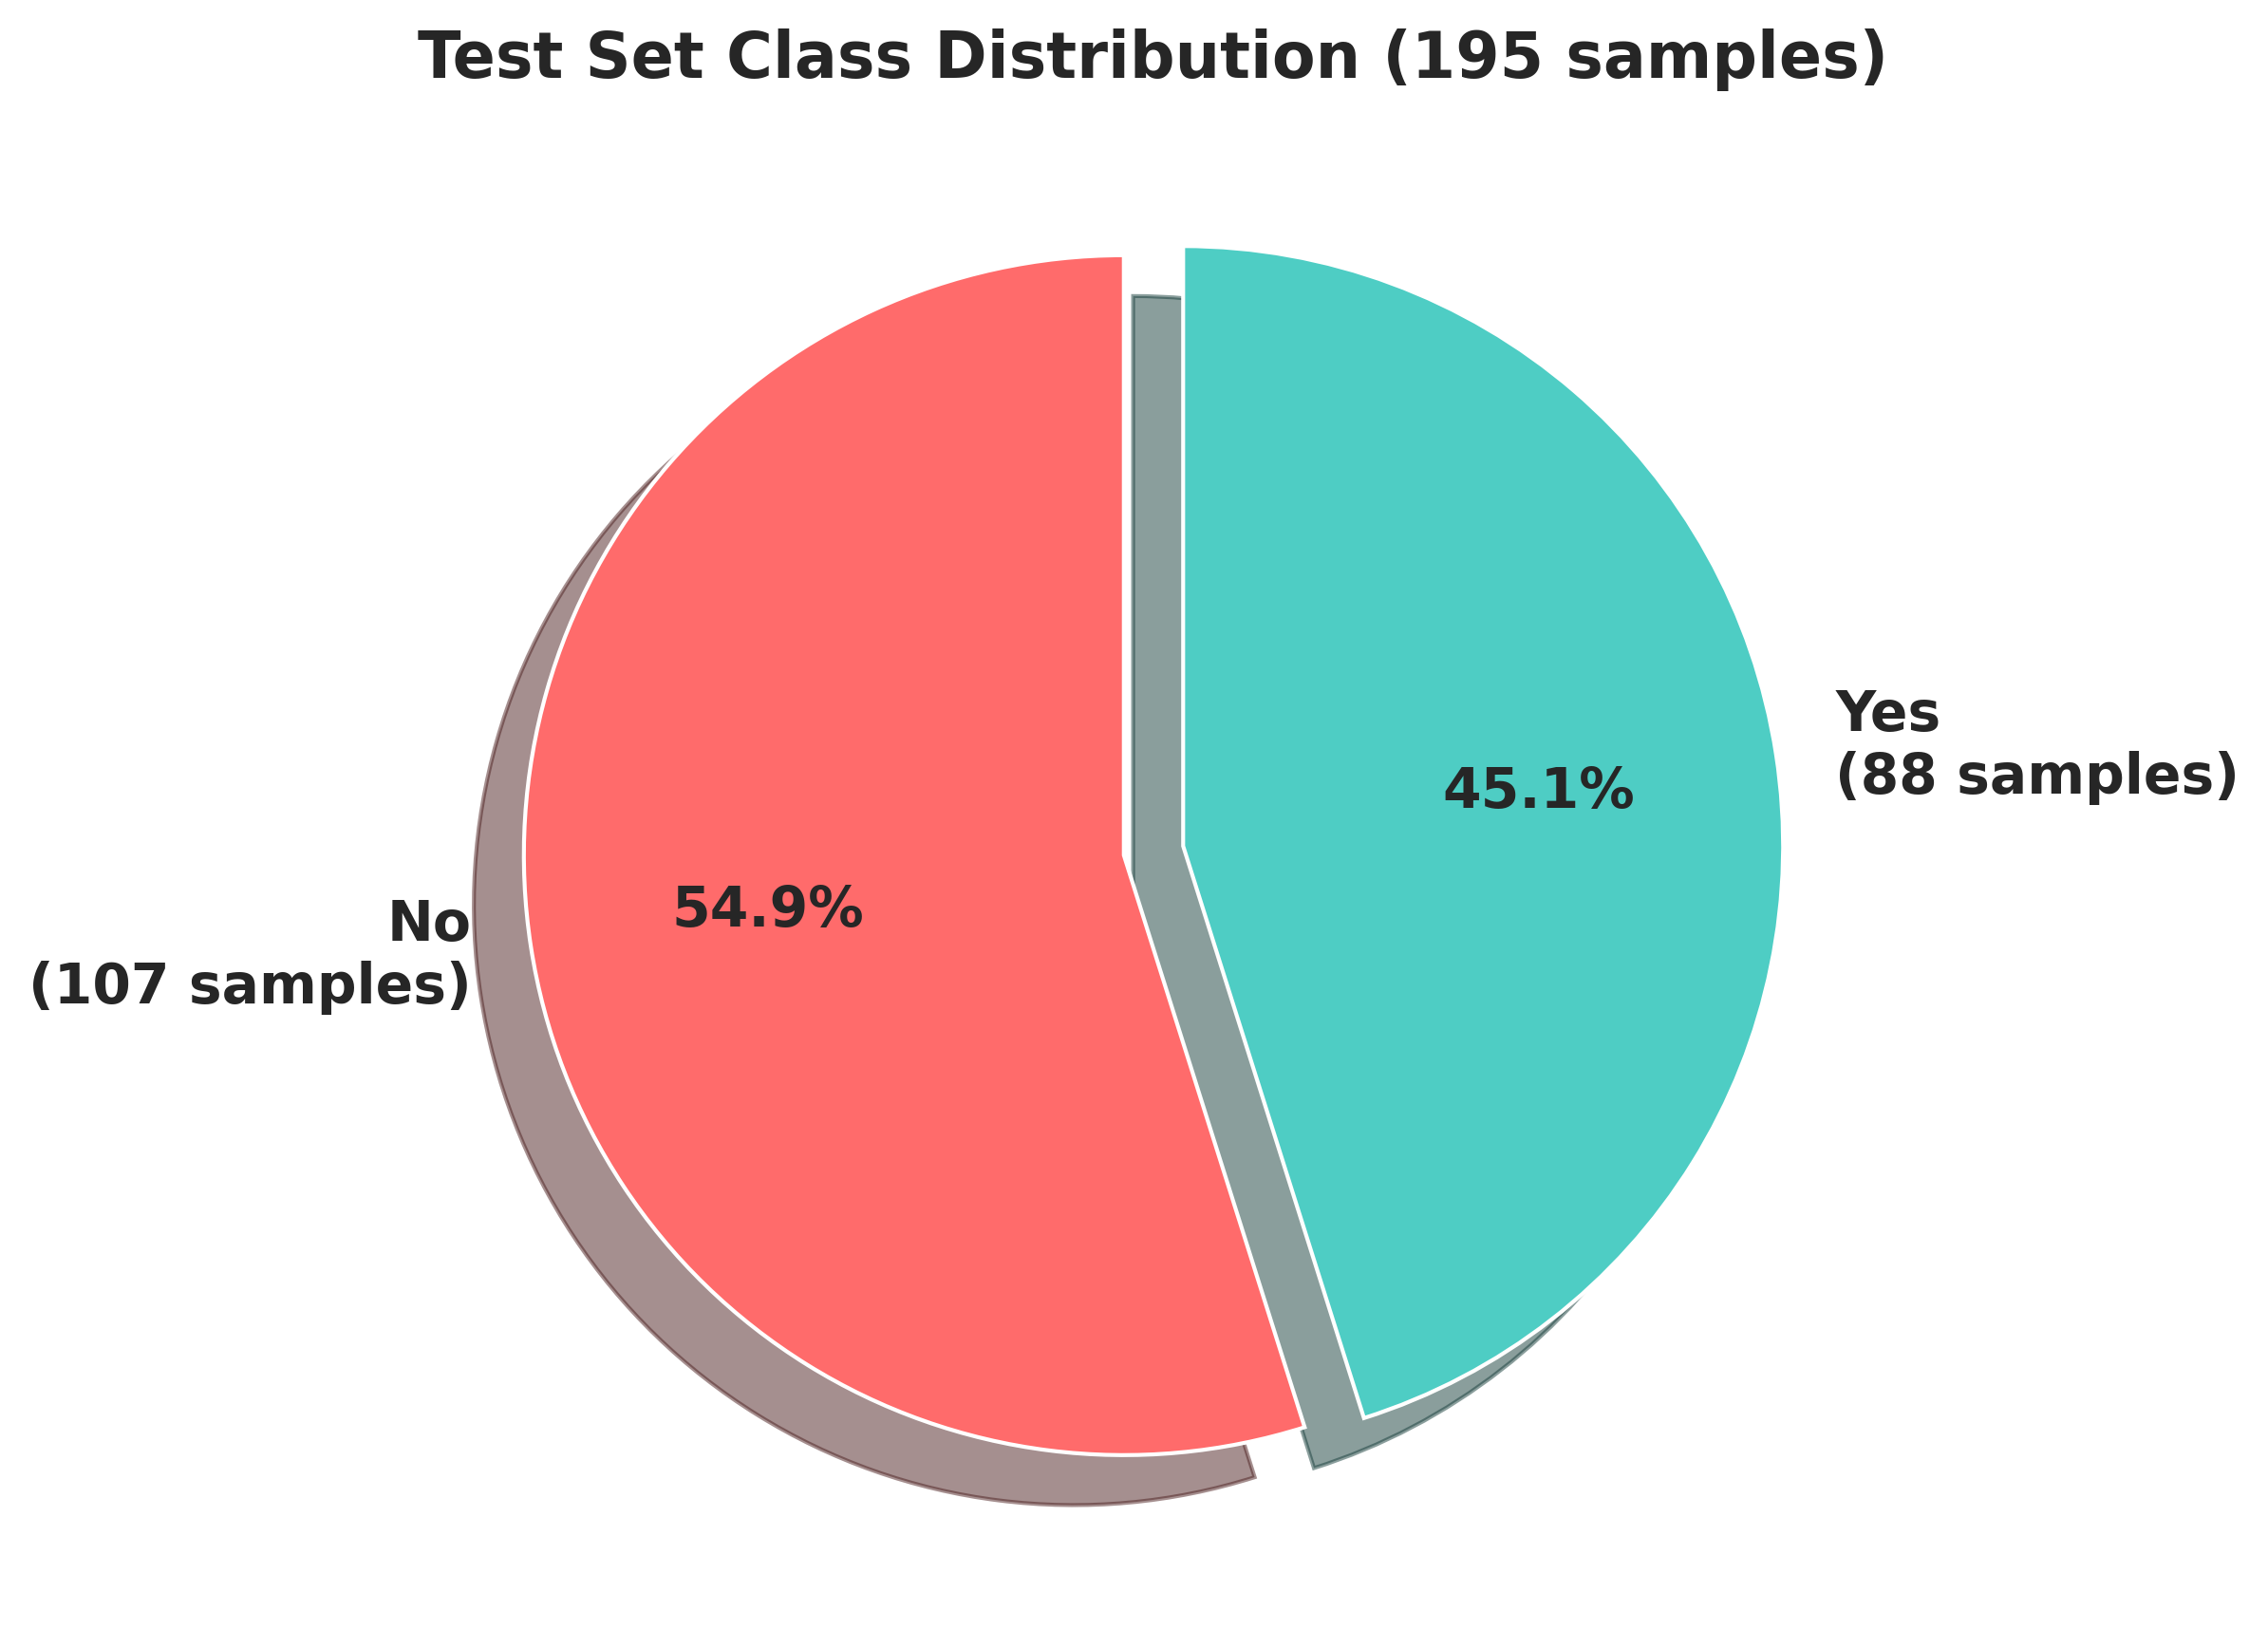

Displaying: 06_model_resources.png


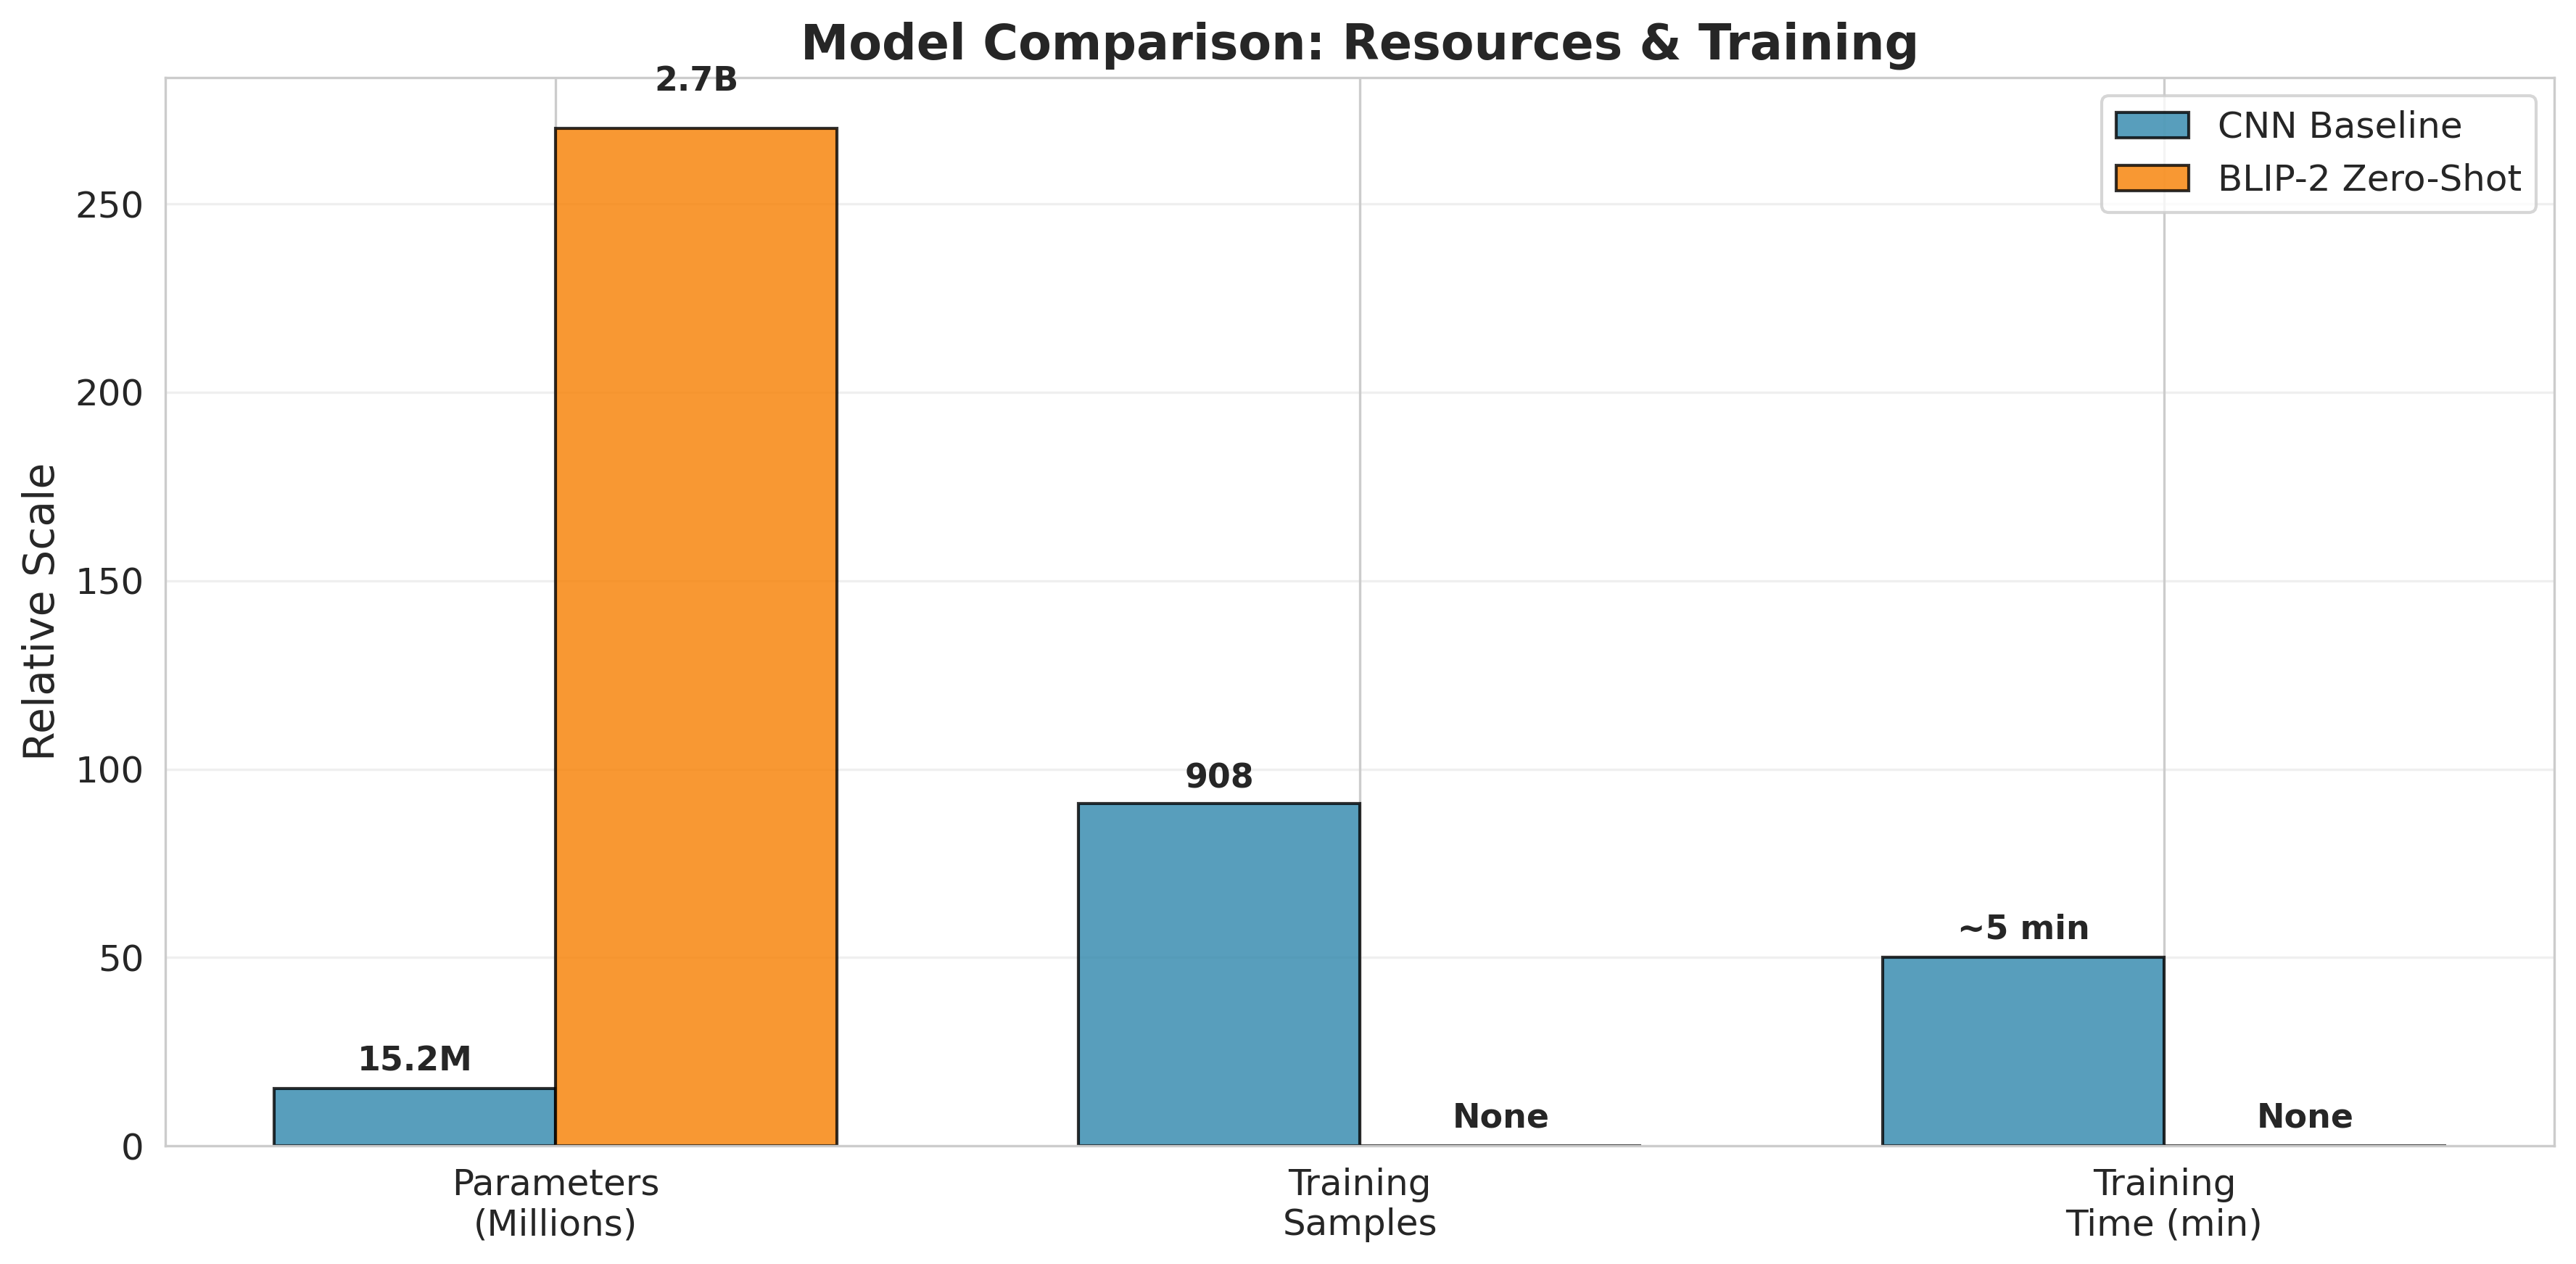

Displaying: 07_recall_bias.png


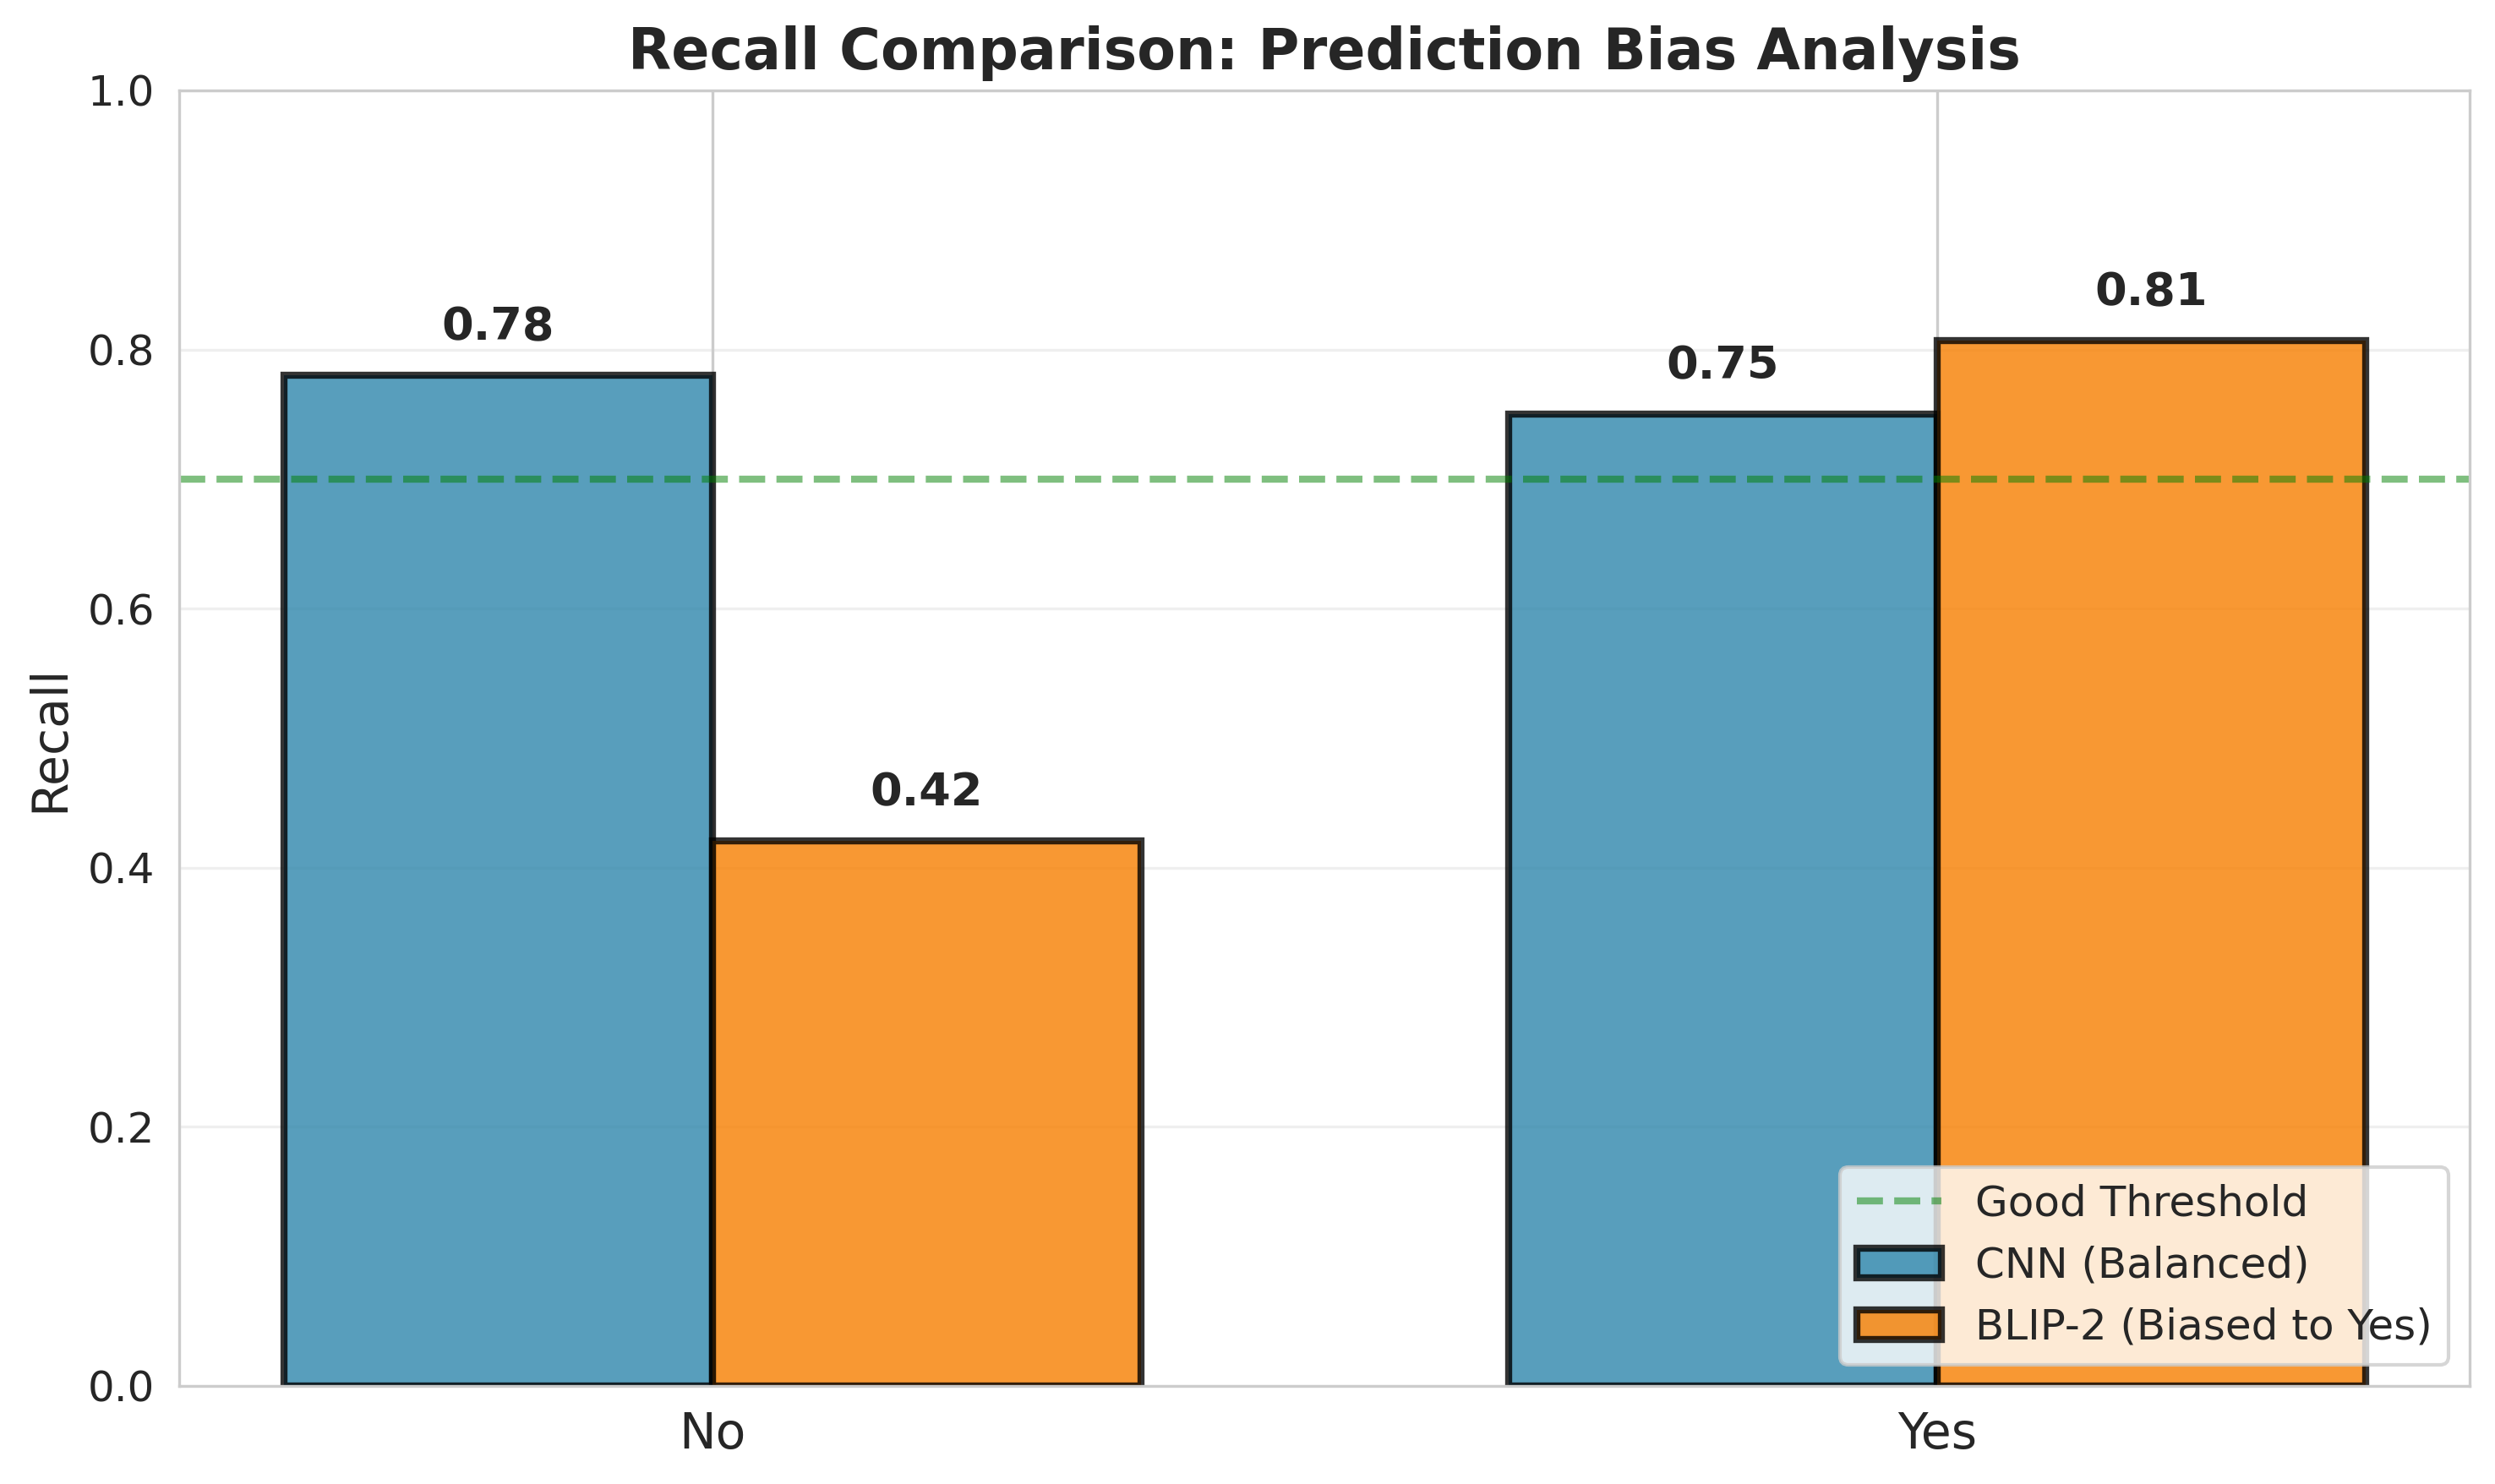

In [31]:
from IPython.display import Image, display

image_folder = f'{SAVE_DIR}/presentation_images'

for image_file in os.listdir(image_folder):
    if image_file.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(image_folder, image_file)
        print(f"Displaying: {image_file}")
        display(Image(filename=image_path))